In [2]:
import pandas as pd
import numpy as np
import pickle
from scipy.sparse import hstack
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from joblib import load
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras_tuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.feature_selection import SelectKBest, f_classif


/var/folders/g5/qt49x61j0n737l58q9zvpq640000gn/T/ipykernel_3983/4048228764.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [3]:
df = pd.read_csv('full_df.csv')
y_df = np.array(df['label'])

# Load engineered features
with open("engineered_features_bow_tfidf.pkl", "rb") as f:
    data = pickle.load(f)

X_bow = data['X_bow']
X_tfidf = data['X_tfidf']
y = data['label']
bow_vectorizer = data['bow_vectorizer']
tfidf_vectorizer = data['tfidf_vectorizer']

X_sparse = hstack([X_bow, X_tfidf])
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)

/Users/sabav/vscode/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/sabav/vscode/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/sabav/vscode/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.1 when using ve

In [4]:
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
general_feature_cols = ['percentage_vb_dt_nn', 'percentage_vb_jj_nn', 'percentage_nn_md_vb']  # example
if set(general_feature_cols).issubset(df.columns):
    general_features = csr_matrix(df[general_feature_cols])
    X_combined = hstack([general_features, X_sparse])
    feature_names = general_feature_cols + list(bow_vectorizer.get_feature_names_out()) + list(tfidf_vectorizer.get_feature_names_out())
else:
    X_combined = X_sparse
    feature_names = list(bow_vectorizer.get_feature_names_out()) + list(tfidf_vectorizer.get_feature_names_out())

In [5]:
selector = SelectKBest(score_func=f_classif, k=500)
X_selected = selector.fit_transform(X_combined, y)

train_size = int(0.8 * X_selected.shape[0])
x_train, x_test = X_selected[:train_size].toarray(), X_selected[train_size:].toarray()
y_train, y_test = y[:train_size], y[train_size:]

Build and train base model

In [6]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, batch_size=16, validation_split=0.2)


/Users/sabav/vscode/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-13 09:30:56.527794: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-13 09:30:56.528097: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-13 09:30:56.528110: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-13 09:30:56.528464: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-13 09:30:56.528617: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created T

Epoch 1/20


2025-04-13 09:30:57.522543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5038/5038 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - accuracy: 0.9021 - loss: 0.2468 - val_accuracy: 0.8956 - val_loss: 0.2575
Epoch 2/20
5038/5038 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.9188 - loss: 0.2386 - val_accuracy: 0.9153 - val_loss: 0.2862
Epoch 3/20
5038/5038 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.9118 - loss: 0.3535 - val_accuracy: 0.8015 - val_loss: 1.1495
Epoch 4/20
5038/5038 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.9023 - loss: 0.5811 - val_accuracy: 0.9299 - val_loss: 0.3771
Epoch 5/20
5038/5038 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.9012 - loss: 0.8958 - val_accuracy: 0.8620 - val_loss: 1.6530
Epoch 6/20
5038/5038 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.8972 - loss: 1.3616 - val_accuracy: 0.9015 - val_loss: 0.8270
Epoch 7/20
5038/5038 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.8962 - loss: 1.4659 - val_accuracy: 0.9135 - val_loss: 0.9825
Epoch 8/20
5038/5038 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.8921 - loss: 2.00

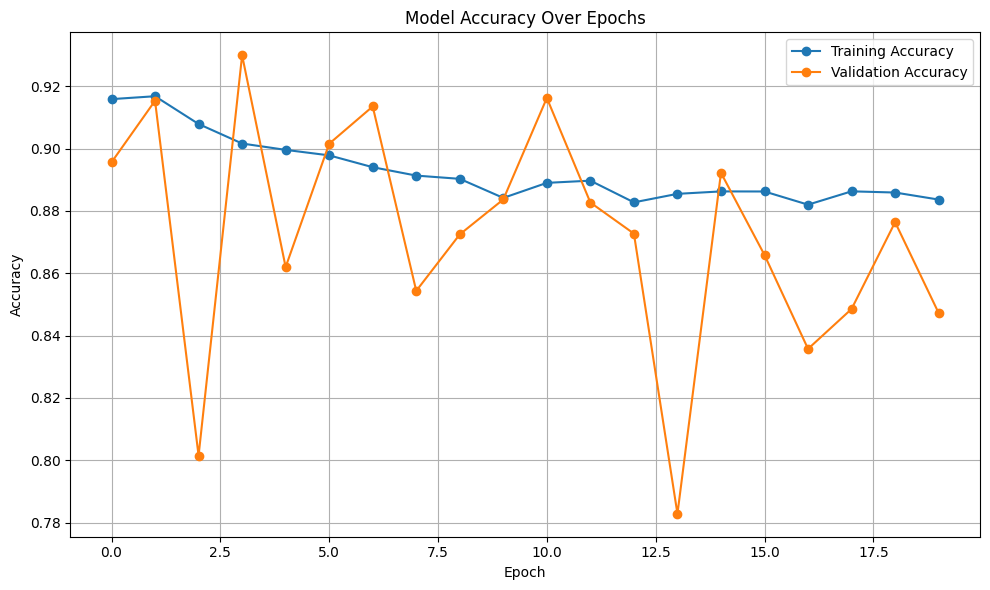

In [7]:
history_df = pd.DataFrame(history.history)

# Accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(history_df['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1. Define Tuner HyperModel

In [9]:
class MyHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units1', 128, 512, step=64), activation='relu', input_dim=self.input_dim))
        model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))
        model.add(Dense(units=hp.Int('units2', 64, 256, step=64), activation='relu'))
        model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

2. Hyperparameter Tuning

In [10]:
tuner = Hyperband(MyHyperModel(x_train.shape[1]), 
                  objective='val_accuracy',
                  max_epochs=10,
                  directory='tuner_dir', 
                  project_name='spam')

tuner.search(x_train, y_train, 
             epochs=50, 
             validation_split=0.1, 
             callbacks=[EarlyStopping(patience=5)])

Trial 30 Complete [00h 03m 16s]
val_accuracy: 0.933207631111145

Best val_accuracy So Far: 0.9369789361953735
Total elapsed time: 00h 56m 17s


3. Final Model & Evaluation

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 384)            │       192,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,793 (944.50 KB)

 Trainable params: 241,793 (944.50 KB)

 Non-trainable params: 0 (0.00 B)

788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


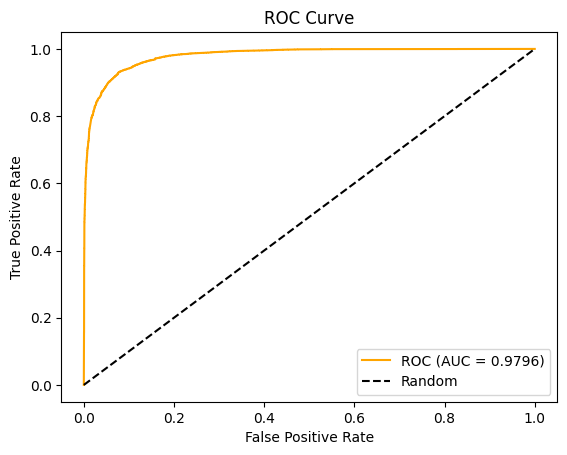

In [11]:
best_model = tuner.get_best_models(1)[0]
best_model.summary()

# Predict and evaluate on test set
y_pred_test = best_model.predict(x_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


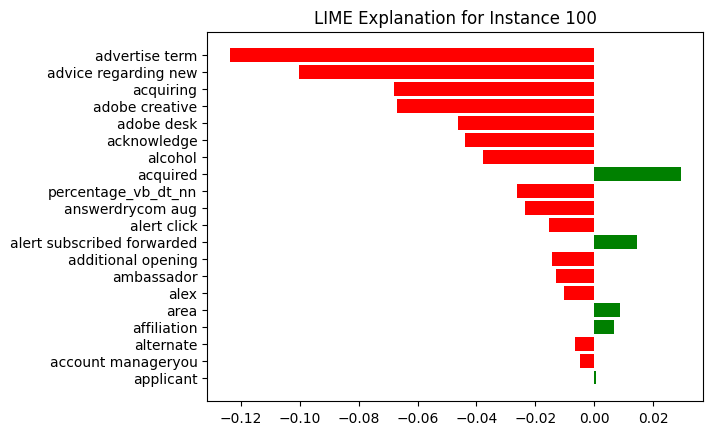

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


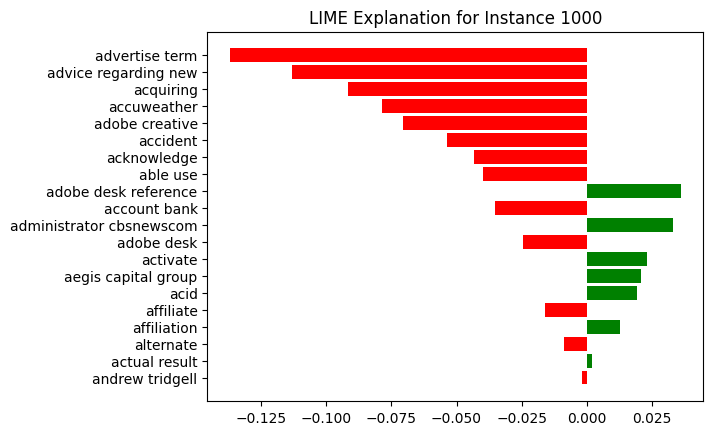

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


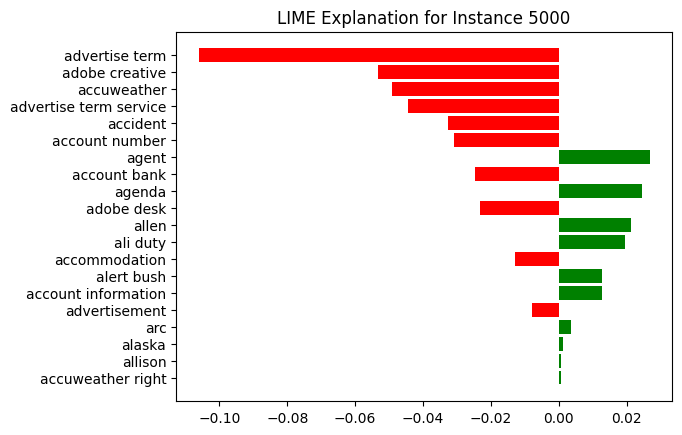

In [25]:
explainer = LimeTabularExplainer(
    training_data=x_train,
    feature_names=feature_names,
    class_names=['not spam', 'spam'],
    discretize_continuous=False,
    mode='classification'
)

def predict_fn(data):
    return np.hstack([1 - model.predict(data), model.predict(data)])

for idx in [100, 1000, 5000]:
    data_row = x_train[idx].ravel()
    exp = explainer.explain_instance(
        data_row=data_row,
        predict_fn=predict_fn,
        num_features=20,
        num_samples=1000
    )
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation for Instance {idx}")
    plt.show()